# **Digit detection and recognition in a noisy image**

This project creates and trains a neural network that detects a single digit in a noisy image. Only a basic understanding of neural networks concepts is needed to understand the explanations and comments below. 

The project is a simple example for the following concepts:
1. Solving a single-image detection and recognition task using a neural net.
2. Using Python & Tensorflow (Keras) to define and train the network.
3. Using Keras to automatically do database augmentation while training.
4. Defining more than one cost function for the learning process. 


**Part 1 - defining the database**

The first step in the code below is to load the digit database. I used the MNIST hand written digits database.

The second step is to define the methods that will create the noisy images database with the embedded digits. For this end a class that inherits tf.keras.utils.Sequence is used. Keras calls this during training (see below) to create batches for the learning process. As a result, Tensorflow will have as large a dataset as it needs to train the model (based on the user's definition of batch size and number of epochs), while the user only has to supply a very small initial database (MNIST digits in this case).

Note that I define the database in order to solve the relatively simple example in which exactly one digit exists in each image. Also note that while the user can define a default noise level via the 'training_snr' variable, the database augmentation method '__getitem__' adds random changes to the noise level to make sure the network can handle images with a variety of different noise levels.

In [0]:
# choose TF version
%tensorflow_version 1.x

# select SNR of images 
training_snr = 0.3

# scaling for image position
posScale = 100

# import
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# load MNIST data (numpy arrays representing digit image)
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# define image and label creation function to be used by model.fit_generator.
# this function adds an MNIST digit (28x28) to a noisy image.
# the label includes the digit class (0-9) and the x-y position of the digit in the image.
class DataGenerator(tf.keras.utils.Sequence):
  # constructor changes (compared to inherited constructor)
  def __init__(self, snr, trainFlag):
    self.snr = snr
    self.trainFlag = trainFlag

  # number of batches in an epoch
  def __len__(self):
    return 50
  
  # batch creation (images and labels)
  def __getitem__(self,index):
      # batch size
      batchSize = 128
      
      # choose noise level
      noise_intensity = 10.0
      snrLevel = self.snr;
      facSignal = np.array([snrLevel*noise_intensity/255.0])
      
      # random indices of samples from MNIST
      if self.trainFlag == 1:
        idxTrain = np.floor( 59999*np.random.rand(batchSize,1) ).astype(int)
      else:
        idxTrain = np.floor( 9999*np.random.rand(batchSize,1) ).astype(int)
      
      # create larger 128x128 canvases, that will be the input layer
      xtrain = noise_intensity*np.random.rand(batchSize,128,128) 
      
      # create random positions
      posx_train = np.floor( 99.0*np.random.rand(batchSize,1) ).astype(int)
      posy_train = np.floor( 99.0*np.random.rand(batchSize,1) ).astype(int)
      
      # create labels for train data
      ytrain = np.zeros((batchSize,12)) # one hot encoding and x-y position
      ytrain[:,10] = posx_train[:,0]/posScale
      ytrain[:,11] = posy_train[:,0]/posScale
      
      # embed numbers in canvas - train data
      ii = 0
      for idx0 in idxTrain:
        # randomize SNR for each image
        snrLevel = self.snr + 3*np.random.rand(1,1);
        facSignal = np.array([snrLevel*noise_intensity/255.0])

        idx = idx0.item()
        i0 = posx_train[ii].item()
        i1 = i0 + 28
        j0 = posy_train[ii].item()
        j1 = j0 + 28
        if self.trainFlag == 1:
          xtrain[ii,i0:i1,j0:j1] = xtrain[ii,i0:i1,j0:j1] + x_train_mnist[idx]*facSignal
          ytrain[ii, y_train_mnist[idx] ] = 1.0 # one hot encoding
        else:
          xtrain[ii,i0:i1,j0:j1] = xtrain[ii,i0:i1,j0:j1] + x_test_mnist[idx]*facSignal
          ytrain[ii, y_test_mnist[idx] ] = 1.0 # one hot encoding
        # normalization
        #xtrain = xtrain / (facSignal*255 + noise_intensity)        
         
        ii = ii + 1

      # reshape images (add dimension)
      xtrain = xtrain.reshape(xtrain.shape[0], 128, 128, 1)/(255*facSignal + noise_intensity)

      # return results
      return xtrain, [ytrain[:,0:10],ytrain[:,10:12]]
      
      #return xtrain, ytrain[:,10:12]

# create batch for debugging purposes
trainFlag = 1
batchCreator = DataGenerator(training_snr,trainFlag)
X, Y = batchCreator.__getitem__(0)


**Part 2 - plotting samples from the database**

The code below uses the 'DataGenerator' class and prints out samples to make sure that the database creation methods work as intended.

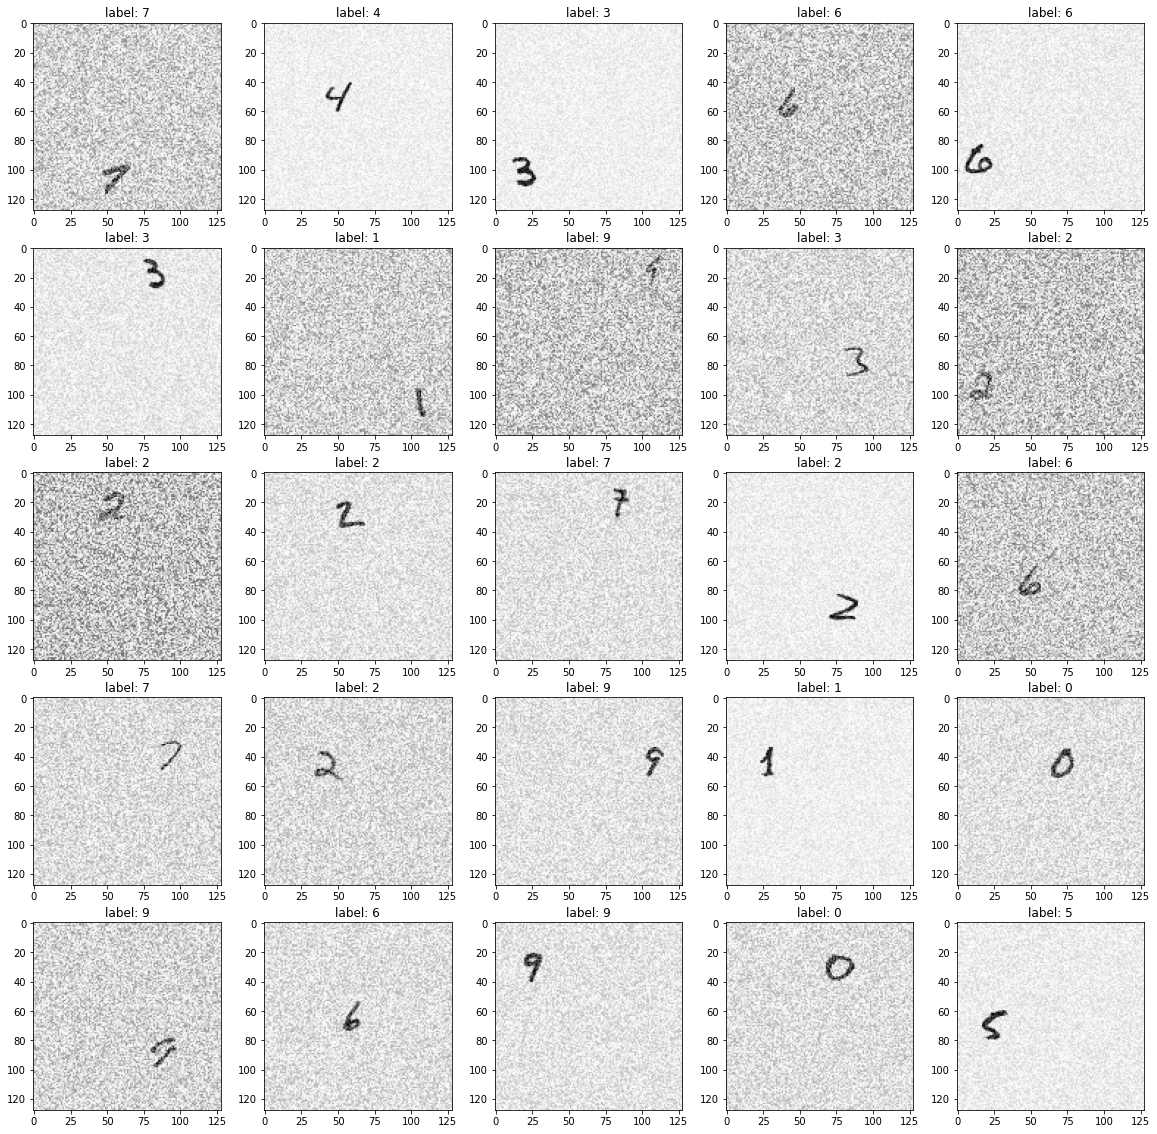

In [19]:
# plot sample
fig, axes = plt.subplots( 5, 5, figsize=(20,20) )
im = 0
for i in range(5):
  for j in range(5):
    # plot image and predicted label
    axes[ i, j ].imshow(X[im,:,:,0], cmap='Greys')
    axes[ i, j ].set_title('label: '+str(np.argmax(Y[0][im])) )

    # propagate image number
    im += 1

plt.show()

**Part 3 - defining the neural net**

The code below uses Keras to define the network and the training loss functions. The network has two output layers: The first output layer is the classification output (a 10x1 layer where each output is in the range [0,1] and represents the probability that the image contains the digit represeted by that output). The second Output layer is a 2x1 layer representing the position of the top left corner of the digit in pixel units. These are two output types that require different optimization criteria. For the classification output I used the 'categorical_crossentropy' loss. For the detection output (digit position in the image) I used the 'mean_squared_error' loss. The detection output also serves as a layer for the detection output - see the network plot below.

In [0]:
# create a keras neural network model

from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Multiply, Input, LeakyReLU, Concatenate,concatenate
from keras import backend as K 

#k_constants = K.variable([[10,128,128]]) 
#ones_tensor = Input(tensor=k_constants)

my_input_shape = (128, 128, 1)

# input layer
xlayer = Input(shape=my_input_shape)

# layers for both nns:
internallayer = Conv2D(16, kernel_size=(5,5), input_shape=my_input_shape, strides=1, padding='valid')(xlayer) 
internallayer = LeakyReLU(alpha=0.1)(internallayer)
internallayer = MaxPooling2D(pool_size=2)(internallayer) # output 2 breaks off here


# only for output2 (position of digit):
internallayer2 = Conv2D(4, kernel_size=(5,5), input_shape=my_input_shape, strides=1, padding='valid')(internallayer)
internallayer2 = LeakyReLU(alpha=0.1)(internallayer2)
internallayer2 = MaxPooling2D(pool_size=2)(internallayer2)
internallayer2 = Conv2D(4, kernel_size=(5,5), strides=1, padding='valid')(internallayer2)
internallayer2 = LeakyReLU(alpha=0.1)(internallayer2)
internallayer2 = MaxPooling2D(pool_size=2)(internallayer2)
internallayer_f2 = Flatten()(internallayer2)
outlayer2 = Dense(2,activation=tf.nn.sigmoid)(internallayer_f2) # output2 (digit position in x and y)

# only for output 1 (type of digit):
internallayer1 = Conv2D(8, kernel_size=(5,5), strides=1, padding='valid')(internallayer)
internallayer1 = LeakyReLU(alpha=0.1)(internallayer1)
internallayer1 = MaxPooling2D(pool_size=2)(internallayer1)
internallayer1 = Conv2D(8, kernel_size=(5,5), strides=1, padding='valid')(internallayer1)
internallayer1 = LeakyReLU(alpha=0.1)(internallayer1)
internallayer1 = MaxPooling2D(pool_size=2)(internallayer1)
internallayer1 = Conv2D(8, kernel_size=(5,5), strides=1, padding='valid')(internallayer1)
internallayer1 = LeakyReLU(alpha=0.1)(internallayer1)
internallayer1 = MaxPooling2D(pool_size=2)(internallayer1)
internallayer_f1 = Flatten()(internallayer1)
concatlayer = concatenate([internallayer_f1, outlayer2],axis=1)
outlayer1 = Dense(10,activation=tf.nn.softmax)(concatlayer) # output 1 (digit type one-hot encoding)


# model
model = Model(inputs=xlayer, outputs=[outlayer1,outlayer2])

# summary of model
print(model.summary())

# compile model  #loss='mean_absolute_error', 
model.compile(optimizer='adam', 
              loss=['categorical_crossentropy','mean_squared_error'],
              metrics=['accuracy'])


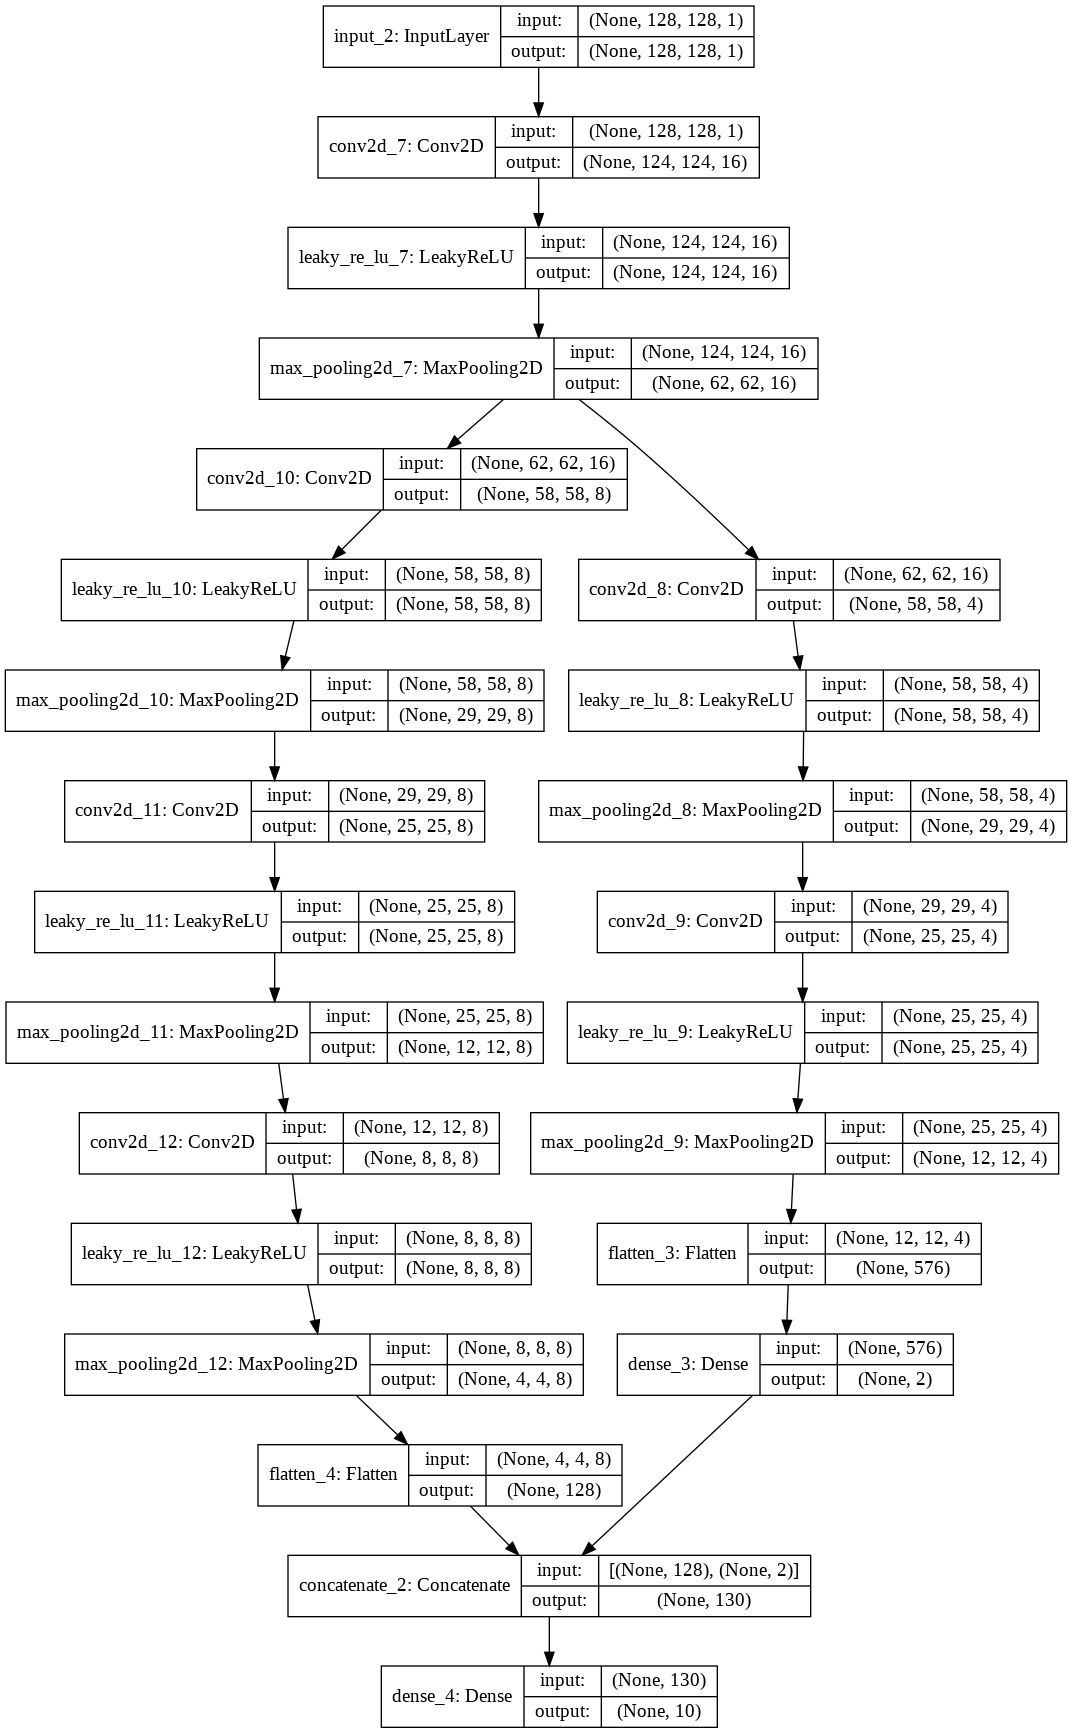

In [31]:
# plot an image of the model
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


**Part 4 - training**

The code below trains the model using the 'DataGenerator' class that automatically creates the random training image database while training. 

In [0]:
# train or load the neural network while creating the database at the same time

if trainFlag == 1:
  batchCreationMethod = DataGenerator(training_snr, trainFlag)
  history = model.fit_generator(batchCreationMethod, epochs=300)

  model.save('modelFindDigitNoisy_type2_lean.h5')  # creates a HDF5 file 

  # plot training loss convergence
  plt.plot(history.history['loss'])
  #plt.plot(history.history['acc'])

else:
  # returns a compiled model
  from keras.models import load_model
  #model = load_model('modelFindDigitNoisy.h5')
  model = load_model('modelFindDigitNoisy_type2.h5')

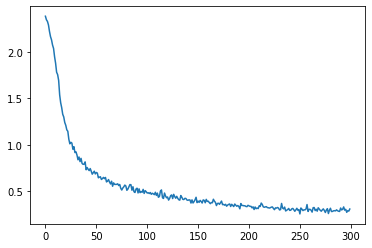

In [32]:
if trainFlag == 1:
  plt.plot(history.history['loss'])

**Part 5 - using the network**

The code below tests the network and plots some results.

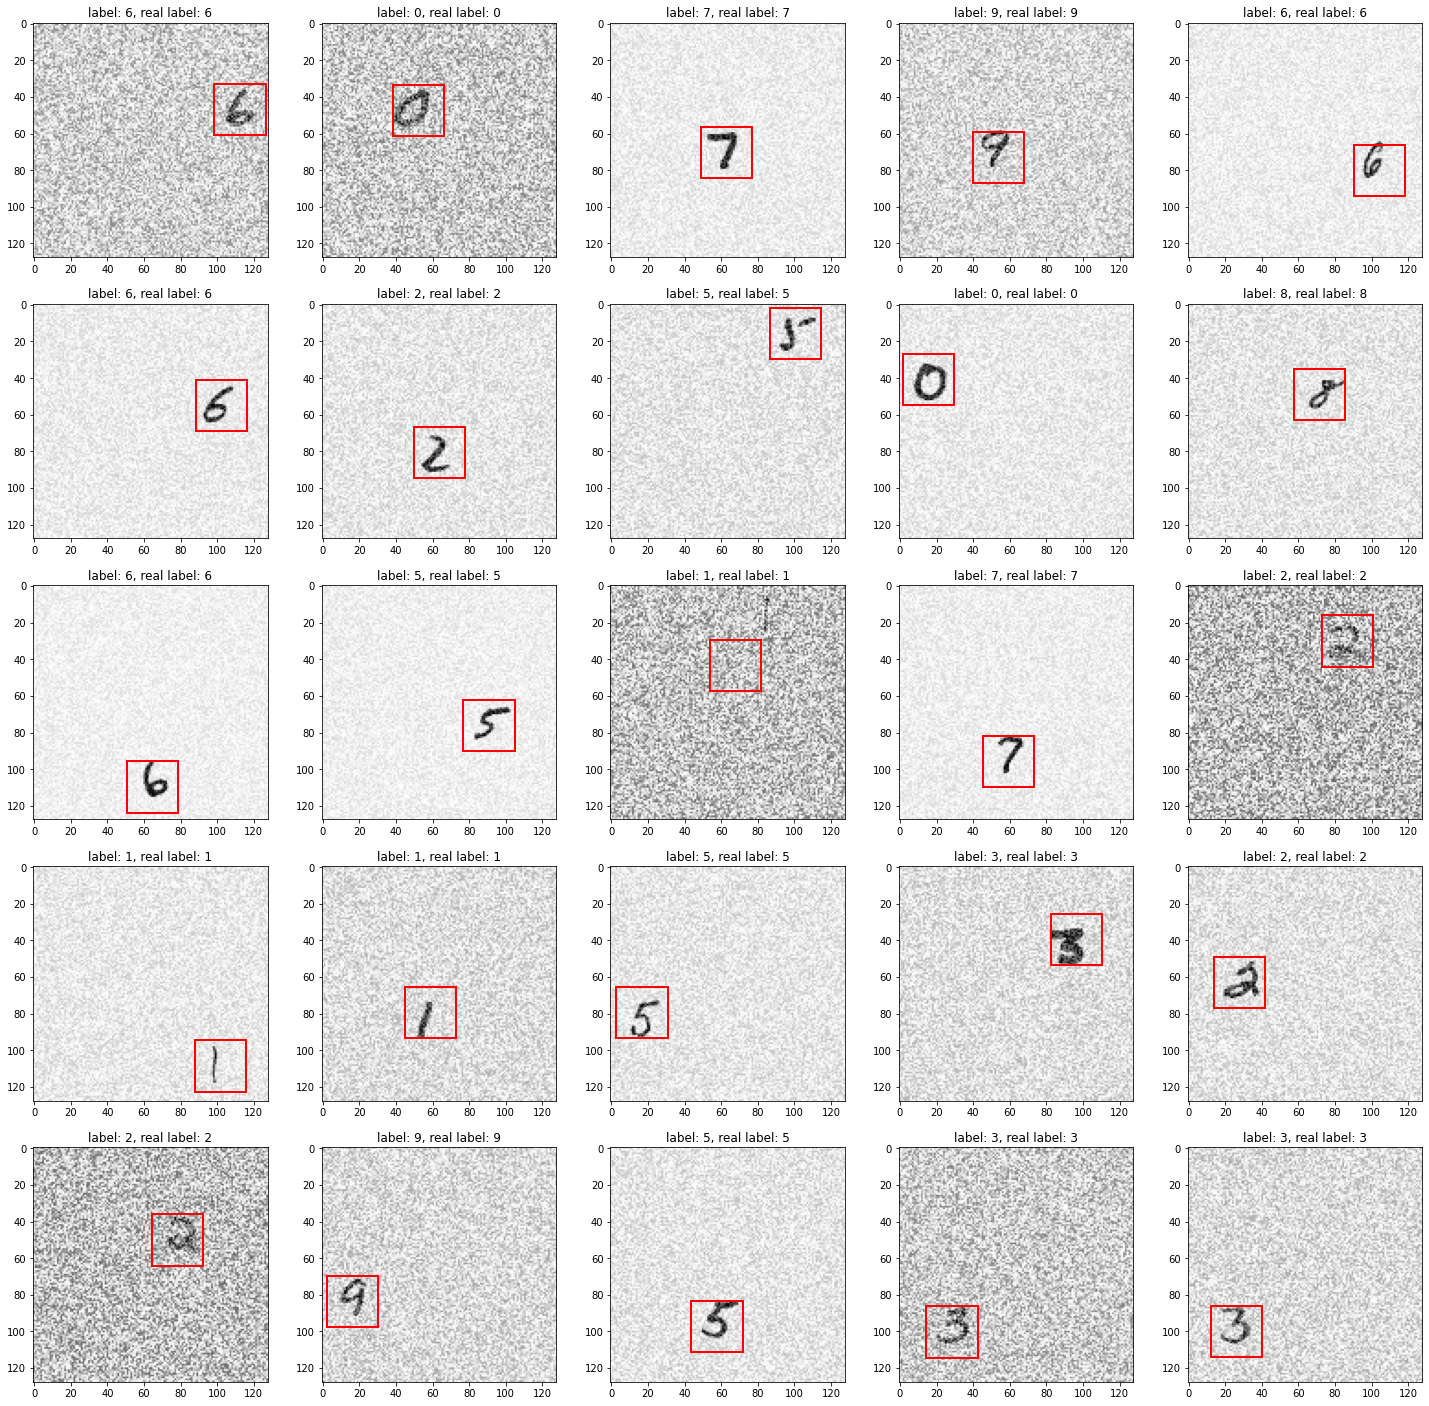

In [27]:
import matplotlib.patches as patches

# testing, not training
trainFlag = 0

# create batch for nn prediction testing
batchCreator = DataGenerator(training_snr, trainFlag)
X1, Y1 = batchCreator.__getitem__(0)

# prediction
pred_out = model.predict(X1[:,:,:,:])

# plot nn prediction sample
fig, axes = plt.subplots( 5, 5, figsize=(25,25) )
im = 0
for i in range(5):
  for j in range(5):
    # plot image and predicted label
    axes[ i, j ].imshow(X1[im,:,:,0], cmap='Greys')
    axes[ i, j ].set_title('label: '+str(np.argmax(pred_out[0][im])) + ', real label: '+str(np.argmax(Y1[0][im])) )

    # add predicted position
    rect = patches.Rectangle((pred_out[1][im,1]*posScale,pred_out[1][im,0]*posScale),28,28,linewidth=2,edgecolor='r',facecolor='none')
    axes[ i, j ].add_patch(rect)

    # propagate image number
    im += 1

plt.show()